In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/person-job-fit/embeddings.csv
/kaggle/input/resume-dataset/preprocessed_resume.csv


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import plot_model
from wordcloud import WordCloud

In [32]:
df = pd.read_csv("/kaggle/input/resume-dataset/preprocessed_resume.csv")

In [33]:
df.head(5)

,resume,label
0,database administrator database administrator ...,database administrator
1,database administrator database administrator ...,database administrator
2,oracle database administrator oracle database ...,database administrator
3,amazon redshift administrator etl developer bu...,database administrator
4,scrum master scrum master scrum master richmon...,database administrator


In [34]:
labels_dict = {}

for idx, label in enumerate(df.label.unique()):
    labels_dict[label] = idx

labels_dict

{'database administrator': 0,
 'systems administrator': 1,
 'project manager': 2,
 'software developer': 3,
 'web developer': 4,
 'network administrator': 5,
 'java developer': 6}

In [35]:
df.label = df.label.apply(func=lambda x: labels_dict[x])
df.label = df.label.astype(np.int64)

In [36]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [41]:
df.head()

,resume,label
0,database administrator database administrator ...,0
1,database administrator database administrator ...,0
2,oracle database administrator oracle database ...,0
3,amazon redshift administrator etl developer bu...,0
4,scrum master scrum master scrum master richmon...,0


In [42]:
tokenizer = AutoTokenizer.from_pretrained("manishiitg/distilbert-resume-parts-classify")
bert_model = TFDistilBertForSequenceClassification.from_pretrained("manishiitg/distilbert-resume-parts-classify",from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [43]:

train_df, test_df = train_test_split(df,test_size=0.3,shuffle=True,random_state=101)

In [45]:
df.describe()

,label
count,24432.000000
mean,2.794491
std,1.790866
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,6.000000


In [46]:
#Text Tokenization
X_train = tokenizer(text=train_df.resume.tolist(),
                   add_special_tokens=True,
                   padding=True,
                   truncation=True,
                   max_length=1050,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

X_test = tokenizer(text=test_df.resume.tolist(),
                  add_special_tokens=True,
                  padding=True,
                  truncation=True,
                  max_length=1050,
                  return_tensors='tf',
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=1)

In [47]:
max_resume_len = 1050

In [49]:
input_ids = Input(shape=(max_resume_len,),dtype=tf.int32,name='input_ids')
attention_masks = Input(shape=(max_resume_len,),dtype=tf.int32,name='attention_mask')

In [54]:
word_embeddings = bert_model(input_ids,attention_mask=attention_masks)[0] # 0 --> final hidden state, 1 --> pooling output

output = Flatten()(word_embeddings)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=7,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_masks],outputs=output)
model.layers

In [55]:
model.layers[2].trainable = True

In [56]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 1050)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 1050)]       0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66962700   ['input_ids[0][0]',              
 assification (TFDistilBertForS  rOutput(loss=None,               'attention_mask[0][0]']         
 equenceClassification)         logits=(None, 12),                                                
                                 hidden_states=None                                         

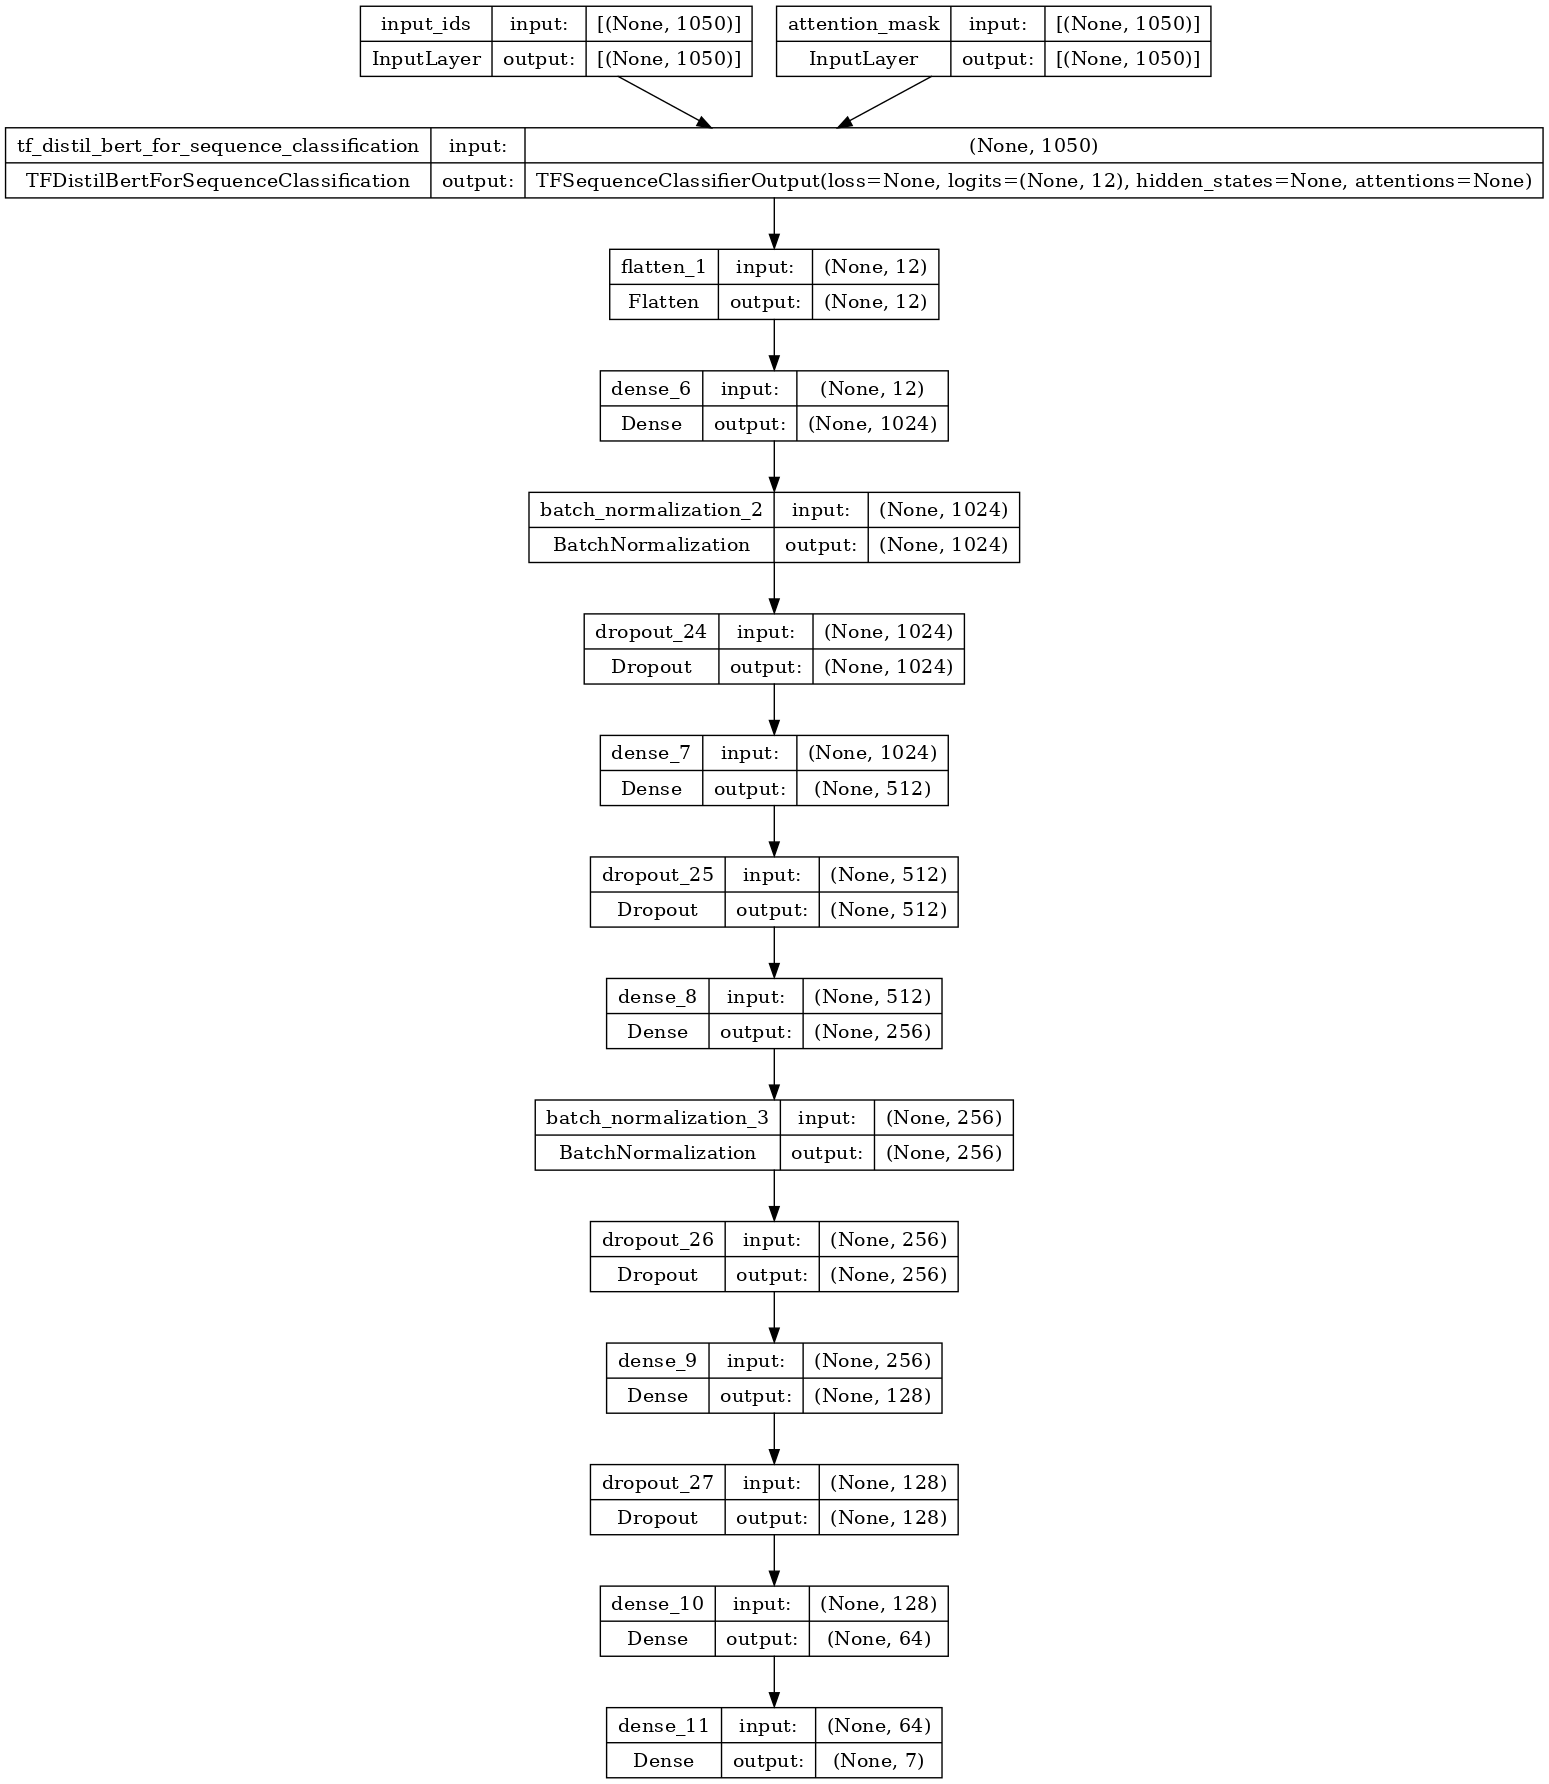

In [57]:
plot_model(model,to_file='model.png',dpi=100,show_shapes=True)

In [60]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=10000,
    decay_rate=0.01)
adam = Adam(learning_rate=lr_schedule)

# adam = Adam(learning_rate=,
#            epsilon=2e-8,
#            decay=0.01,
#            clipnorm=1.0)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=SparseCategoricalAccuracy('balanced_accuracy'))

In [68]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=250,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint('resume_parser.h5',monitor='val_balanced_accuracy',mode='max',verbose=1,save_best_only=True)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=train_df.label,
             epochs=2,
             batch_size=8,
             callbacks=[es,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.label))

Epoch 1/2
2138/2138 [==============================] - ETA: 0s - loss: 0.4214 - balanced_accuracy: 0.8945
Epoch 1: val_balanced_accuracy improved from -inf to 0.92592, saving model to resume_parser.h5
2138/2138 [==============================] - 2839s 1s/step - loss: 0.4214 - balanced_accuracy: 0.8945 - val_loss: 0.3018 - val_balanced_accuracy: 0.9259
Epoch 2/2
2138/2138 [==============================] - ETA: 0s - loss: 0.3442 - balanced_accuracy: 0.9181
Epoch 2: val_balanced_accuracy improved from 0.92592 to 0.92906, saving model to resume_parser.h5
2138/2138 [==============================] - 2842s 1s/step - loss: 0.3442 - balanced_accuracy: 0.9181 - val_loss: 0.2872 - val_balanced_accuracy: 0.9291


In [70]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.label)
print("Test Sparse Categorical Crossentropy Loss:", loss)
print("Test Balanced Categorical Accuracy:", acc)

230/230 [==============================] - 363s 2s/step - loss: 0.2872 - balanced_accuracy: 0.9291
Test Sparse Categorical Crossentropy Loss: 0.2872300148010254
Test Balanced Categorical Accuracy: 0.9290586709976196


In [71]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
test_predictions

230/230 [==============================] - 364s 2s/step


array([1, 1, 2, ..., 1, 5, 0])

In [74]:
print("Confusion Matrix:")
print(confusion_matrix(test_df.label,test_predictions))
print("Classification Report:")
print(classification_report(test_df.label,test_predictions))

Confusion Matrix:
[[ 830    7    7   11    7    2    4]
 [   6 1173   16    7    5   14    5]
 [   6   27  950   17   17   26    1]
 [   8    2   11 1568   89    0   36]
 [   1    3    3   52  977    2    8]
 [   1   56   17    4    2  593    0]
 [   1    2    2   21   14    0  719]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       868
           1       0.92      0.96      0.94      1226
           2       0.94      0.91      0.93      1044
           3       0.93      0.91      0.92      1714
           4       0.88      0.93      0.91      1046
           5       0.93      0.88      0.91       673
           6       0.93      0.95      0.94       759

    accuracy                           0.93      7330
   macro avg       0.93      0.93      0.93      7330
weighted avg       0.93      0.93      0.93      7330



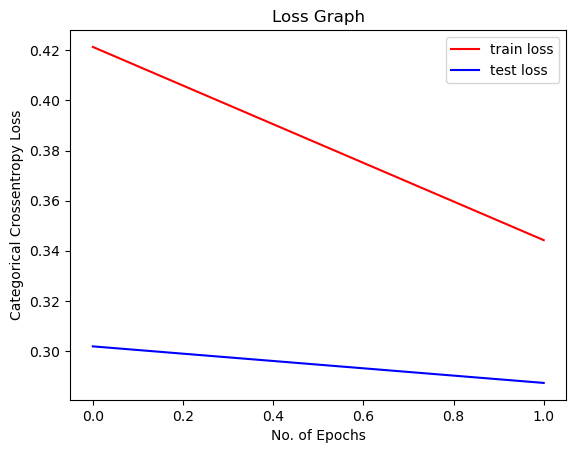

In [75]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

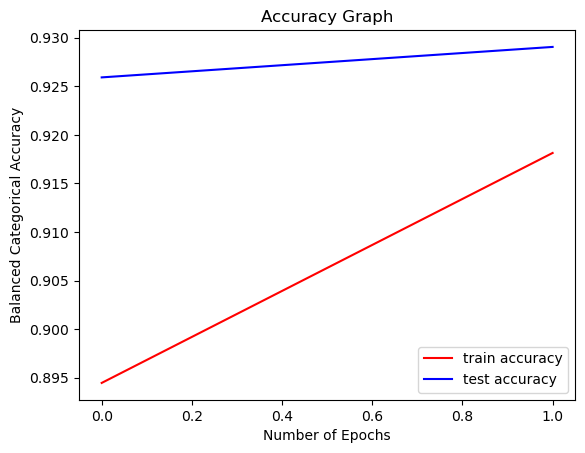

In [76]:
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Balanced Categorical Accuracy')
plt.title('Accuracy Graph')
plt.legend();